### 유튜브 트렌드 알아내기
- ~~최근 영상의 텍스트를 추출해 현재 핫한 영상들의 트렌드를 알아내기~~
- ~~카테고리별로 분류에서 그 분야의 트렌드를 알아낼 수도 있음~~
- 크롤링에 많은 자원이 필요해 원하는 채널의 최근 동향을 알아내는 것으로 수정
- HOW?
    - https://youtubetranscript.com/
    - 위 사이트에서 대본을 크롤링 하기
- 돈 되나?
    - 트렌드에 민감해야 하는 기업이나 단체에 도움이 될 듯
- TODO
    - 한국어 불용어 추가

### Process
1. 특정 유튜버의 최근 영상의 링크 크롤링
2. 영상들의 대본 크롤링
3. 대본에서 stopwords 필터링 (https://gist.github.com/rg089/35e00abf8941d72d419224cfd5b5925d)
4. word cloud에 표시

In [3]:
import datetime
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd

In [4]:
API_KEY = open('api_key').read()

STOPWORDS_PATH = 'stopwords.txt'
FONT_PATH = 'SeoulNamsanB.ttf'

YOUTUBE_CHANNEL_URL_BASE = 'https://www.youtube.com/@'
YOUTUBE_API_URL_BASE = 'https://www.googleapis.com/youtube/v3/search?part=snippet'
YOUTUBE_URL_BASE = 'https://youtu.be/'
SCRIPT_GETTER_URL_BASE = 'https://youtubetranscript.com/?v='


In [5]:
def get_channel_id(channel_handle):
    channel_url = YOUTUBE_CHANNEL_URL_BASE + channel_handle
    response = requests.get(channel_url)
    soup = bs(response.text, 'html.parser')
    channel_id = soup.find('meta', {'itemprop':'identifier'}).get('content')
    return channel_id

def get_since_days_ago(days):
    now = datetime.datetime.now()
    from_date = now - datetime.timedelta(days=days)
    from_date_string = from_date.isoformat("T") + "Z"
    return from_date_string

def make_api_url(channel_id, since_days_ago=30, max_results=10):
    from_date = get_since_days_ago(since_days_ago)

    url = (YOUTUBE_API_URL_BASE
        + f"&channelId={channel_id}"
        + f"&publishedAfter={from_date}"
        + f"&maxResults={max_results}"
        + f"&order=date"
        + f"&type=video"
        + f"&key={API_KEY}"
    )

    return url

def get_video_ids(api_url):
    video_ids = []
    response = requests.get(api_url)
    if response.status_code == 200: # success
        videos = response.json()
        for item in videos.get('items', []):
            video_ids.append(item['id']['videoId'])
    else:
        print(f"Error: {response.status_code}")
        print(response.json())
    
    return video_ids

In [6]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from webdriver_manager.chrome import ChromeDriverManager

In [7]:
def get_webdriver():
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

def get_script(video_id):
    driver = get_webdriver()

    script = ''
    try:
        script_getter_url = SCRIPT_GETTER_URL_BASE + video_id
        driver.get(script_getter_url)

        WebDriverWait(driver, 15).until(
            lambda x: len(x.find_elements(By.CSS_SELECTOR, "a.youtube-marker")) > 0
        )

        page_source = driver.page_source
        soup = bs(page_source, 'html.parser')
        script = soup.find("div", {"id": "demo"}).text.lower()
        print(f"Done for getting script of {YOUTUBE_URL_BASE + video_id}\n", end='')
    except Exception as e:
        print(f"Failed for getting script of {YOUTUBE_URL_BASE + video_id}\n", end='')
    finally:
        driver.quit()
        return script

In [8]:
# load stopwords
stopwords = set()
for line in open(STOPWORDS_PATH, 'r'):
    stopword = line.strip()
    stopwords.add(stopword)

In [9]:
import re

def remove_bracketed_text(script):
    return re.sub(r'\[.*?\]', '', script)

def remove_stopwords(script):
    words = re.findall(r'\b\w+\b', script)
    filtered_words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(filtered_words)

def clean_script(script):
    script = remove_bracketed_text(script)
    script = remove_stopwords(script)
    return script

In [10]:
channel_handle = 'golangkorea8237'

channel_id = get_channel_id(channel_handle)
api_url = make_api_url(channel_id, since_days_ago=30, max_results=30)
video_ids = get_video_ids(api_url)

print(f"Found {len(video_ids)} videos.")

Found 17 videos.


In [11]:
# 크롤링에 많은 시간이 필요해 멀티스레딩 이용

from concurrent.futures import ThreadPoolExecutor

def get_scripts_parallel(video_ids, max_workers=5):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(get_script, video_ids))
    return results

In [12]:
df = pd.DataFrame(video_ids, columns=('video_id',))
df['script'] = get_scripts_parallel(video_ids, max_workers=10)
df['cleaned_script'] = df['script'].apply(clean_script)
df

Done for getting script of https://youtu.be/sUbWWplg9Iw
Done for getting script of https://youtu.be/l42VTNbWKaI
Done for getting script of https://youtu.be/U5AQkycrvaU
Done for getting script of https://youtu.be/gTw7gTJ4r2Y
Done for getting script of https://youtu.be/1GP_M5w7vtU
Done for getting script of https://youtu.be/o844Ghyjfnw
Done for getting script of https://youtu.be/bDA4RAc1hmQ
Done for getting script of https://youtu.be/4DqcjCtgQ2k
Done for getting script of https://youtu.be/YoG7ac5w6Mg
Done for getting script of https://youtu.be/8BDGRsdUtpc
Done for getting script of https://youtu.be/NVqVS64qClk
Done for getting script of https://youtu.be/Wzge0hb_MSE
Done for getting script of https://youtu.be/47dl9vXdt4o
Done for getting script of https://youtu.be/iZuKawFBo98
Done for getting script of https://youtu.be/EVBFXZhS07E
Done for getting script of https://youtu.be/75X_eBW0mog
Done for getting script of https://youtu.be/7HXsDN_Kxug


,video_id,script,cleaned_script
0,bDA4RAc1hmQ,[applause]mia so say say hello to our particip...,mia participantand presentation pleaseokay guy...
1,1GP_M5w7vtU,안녕하세요버그없는 프로그램 만들기 테스팅관점으로 근데 이제 블록체인을 곁들인이런 주...,안녕하세요버그없는 프로그램 만들기 테스팅관점으로 근데 이제 블록체인을 곁들인이런 주...
2,gTw7gTJ4r2Y,네 안녕하세요 저는시나리오 테스트 인스테스트 자동화로자신감 생산성 높이기라는 주제로...,네 안녕하세요 저는시나리오 테스트 인스테스트 자동화로자신감 생산성 높이기라는 주제로...
3,4DqcjCtgQ2k,아네 안녕하세요 저는 그 오늘api 서버 테스트 코드 a2z케이스별효과적인 테스트 ...,아네 안녕하세요 저는 그 오늘api 서버 테스트 코드 a2z케이스별효과적인 테스트 ...
4,sUbWWplg9Iw,네 안녕하세요프로파일링 & 트레이싱 칩스인 고란주제로 발표할 박재안입니다 오늘발표에...,네 안녕하세요프로파일링 트레이싱 칩스인 고란주제로 발표할 박재안입니다 오늘발표에서는...
5,8BDGRsdUtpc,네 안녕하십니까굿테스트의 거의 모든 것 실습으로쉽게 알아보자고에 대한 발표를시작하겠...,네 안녕하십니까굿테스트의 거의 모든 것 실습으로쉽게 알아보자고에 대한 발표를시작하겠...
6,U5AQkycrvaU,안녕하세요 저는 이번에 그 서버모니터링을 고랭으로 만드는 주제에대해서 발표를 최정민...,안녕하세요 저는 이번에 그 서버모니터링을 고랭으로 만드는 주제에대해서 발표를 최정민...
7,l42VTNbWKaI,네 안녕하세요네 이번 코퍼콘에서aws인고 위드 카프카라는 주제로발표를 하게 된 김수...,네 안녕하세요네 이번 코퍼콘에서aws인고 위드 카프카라는 주제로발표를 하게 된 김수...
8,YoG7ac5w6Mg,네안녕하세요 이번 발표를 하게 된현대자동차의박도형이라고 합니다감사합니다앞에서 이제 ...,네안녕하세요 이번 발표를 하게 된현대자동차의박도형이라고 합니다감사합니다앞에서 이제 ...
9,o844Ghyjfnw,안녕하세요 컨테스트를 통한 상태관리발표를 맡은 아프리카tv의권용민이라고 합니다아마 ...,안녕하세요 컨테스트를 통한 상태관리발표를 맡은 아프리카tv의권용민이라고 합니다아마 ...


In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [14]:
max_words = 200
joined = ' '.join(df['cleaned_script'])
word_cloud = WordCloud(
    max_words=max_words,
    width=600,
    height=600,
    font_path=FONT_PATH).generate(joined)

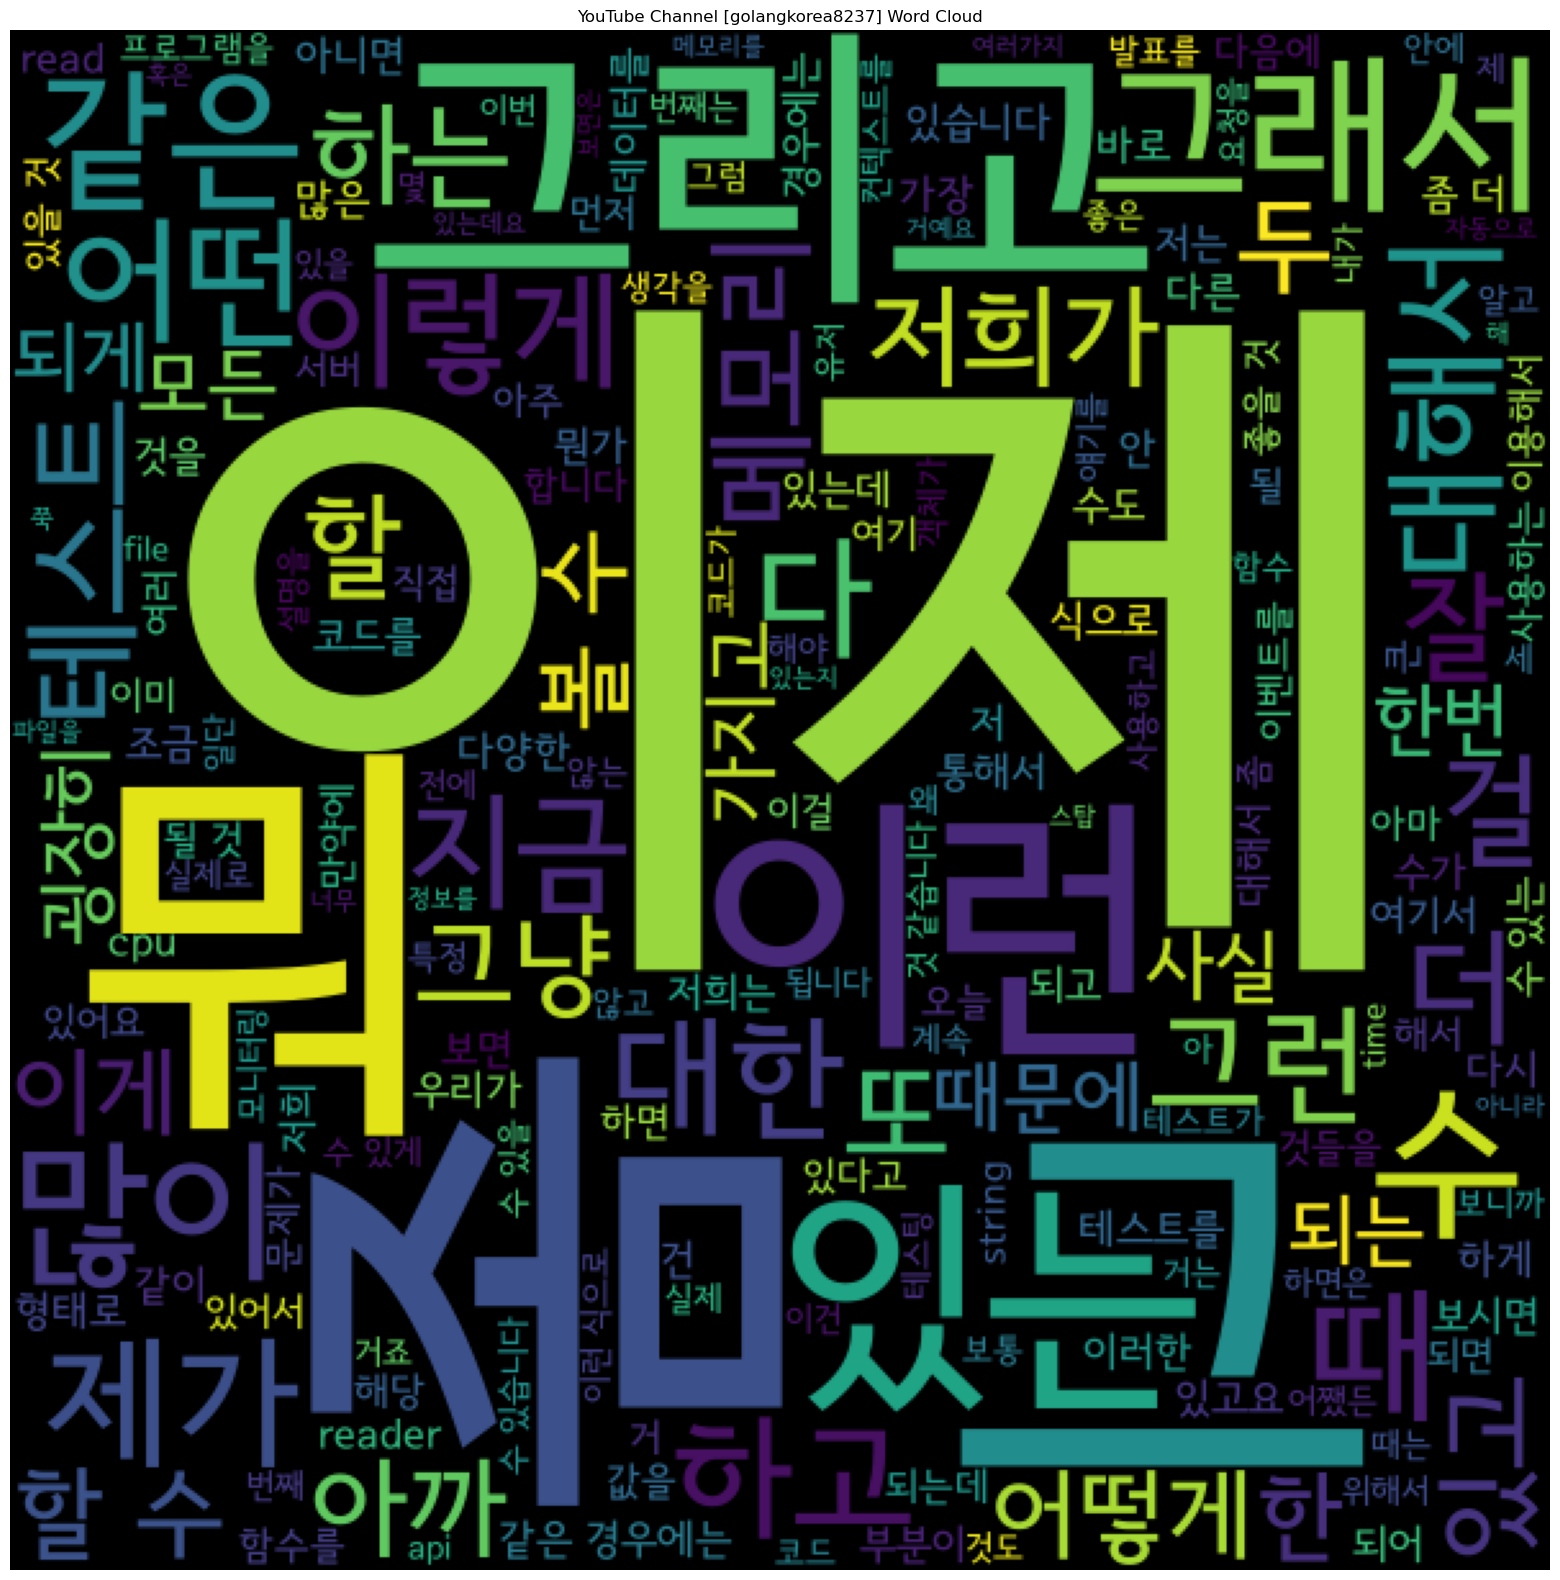

In [15]:
plt.figure(figsize=(20, 20))
plt.imshow(word_cloud)
plt.title(f"YouTube Channel [{channel_handle}] Word Cloud")
plt.axis("off")
plt.show()